# Задача 5. Обучение без учителя

- Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- При обучении использовать **подбор гиперпараметров**.
- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.- (**+3 балла**) Для подбора гиперпараметров использовать фреймворк **Optuna**.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pathlib

# устанавливаем точность чисел с плавающей точкой
%precision % .4f

import warnings

warnings.filterwarnings('ignore')  # отключаем предупреждения
dataset_path = pathlib.Path().resolve().parent / "datasets" / "handwritten_data" / "handwritten_data.csv"

# Датасет
Будет использован [Датасет](https://www.kaggle.com/datasets/ashishguptajiit/handwritten-az), который состоит из 372038 изображений 28x28.

Первая колонка содержит в себе букву, которая нарисована.
- *0* A
- *1* B
- ...
- *25* Z

Так как мой компьютер не потянет столько значений, то я с помощью скрипта отобрал по 500 изображений каждой буквы

In [44]:
df = pd.read_csv(dataset_path)

# 1.EDA

In [45]:
df.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.598,0.599,0.600,0.601,0.602,0.603,0.604,0.605,0.606,0.607
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Заменим названия колонок на более понятные

In [46]:
rename_dict = {}
i = 0

for column in df:
    rename_dict[column] = f"pixel{i}"
    i += 1

df.rename(columns=rename_dict, inplace=True)
df.rename(columns={"pixel0": "label"}, inplace=True)

In [47]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12839 entries, 0 to 12838
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 76.9 MB


In [49]:
labels = df["label"]
labels.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [50]:
labels.value_counts()

13    500
1     500
24    500
23    500
22    500
20    500
19    500
18    500
17    500
16    500
15    500
14    500
25    500
12    500
11    500
10    500
9     500
8     500
7     500
6     500
5     500
4     500
3     500
2     500
0     499
21    340
Name: label, dtype: int64

In [51]:
df.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [52]:
df.drop(columns=["label"], inplace=True)

# PCA & t-SNE

In [53]:
%%time
from sklearn.decomposition import PCA
pca = PCA()

pca_res = pca.fit_transform(df)

CPU times: user 6.33 s, sys: 7.71 s, total: 14 s
Wall time: 1.65 s


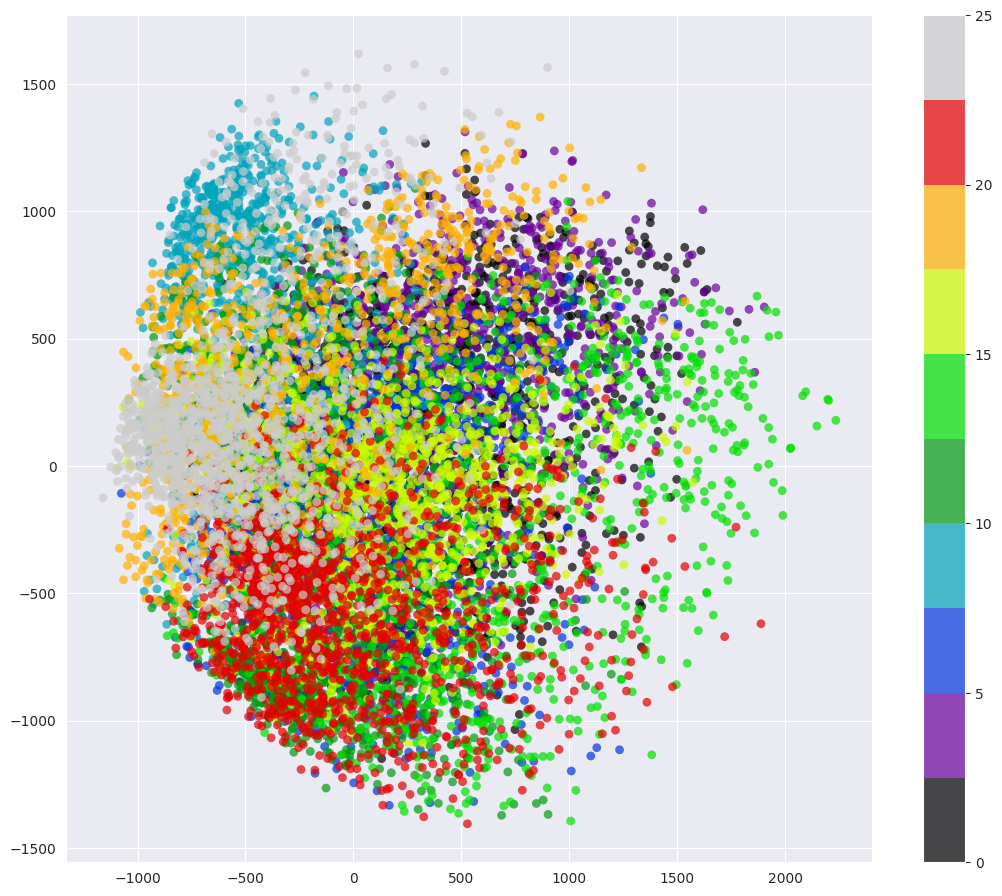

In [54]:
plt.figure(figsize=(13, 11))
plt.scatter(pca_res[:, 0], pca_res[:, 1], c=labels,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

In [55]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE().fit_transform(df)

CPU times: user 3min 19s, sys: 2.84 s, total: 3min 22s
Wall time: 22.5 s


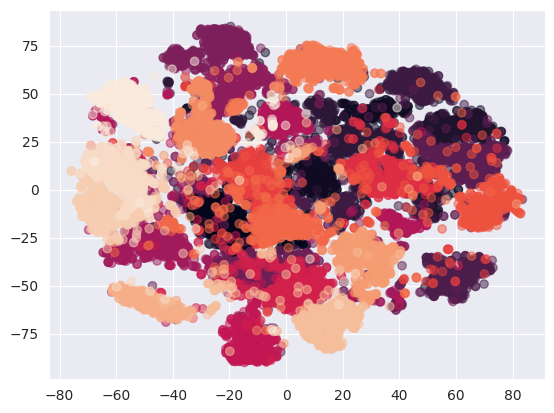

In [56]:
plt.scatter(tsne[:,0], tsne[:,1], c=labels, alpha=0.5);

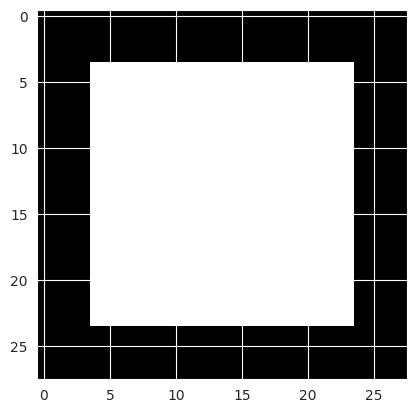

In [57]:
plt.imshow(df.max().values.reshape([28, 28]), cmap="gray");

Видим, что очень много неиспользумых пикселей
Выясним, сколько из пикселей содержат в себе наибольшую часть информации


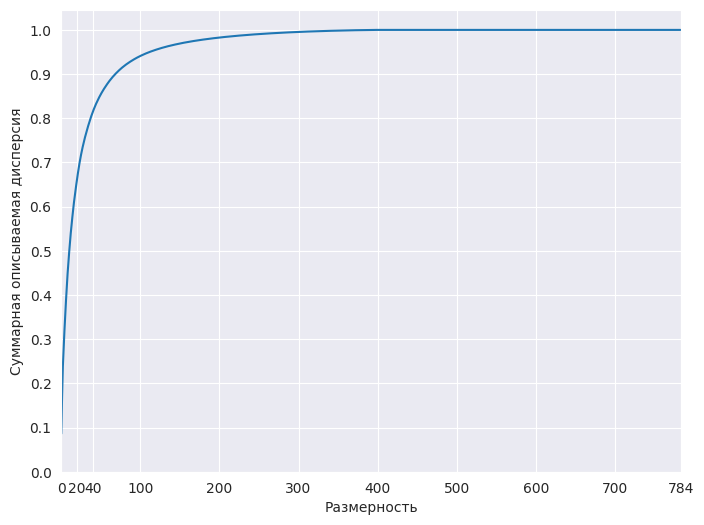

In [58]:
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Размерность")
plt.ylabel("Суммарная описываемая дисперсия")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks([*plt.xticks()[0], 20, 40, 28 * 28])
plt.xlim(0, 28 * 28)
plt.grid(True)

Уже при размерности 40, можно описать 80% дисперсии.

# Реализации алгоритма

In [59]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted

class SelfWritedKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def predict(self, x):
        check_is_fitted(self)
        return self._get_labels(check_array(x))

    def fit(self, x, y=None):
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        x = check_array(x)

        self.n_features_in_ = x.shape[1]
        self.cluster_centers_ = x[self.random_state_.choice(len(x), size=self.n_clusters, replace=False), :]
        max_center_shift = np.inf

        while max_center_shift > self.tol:
            self.labels_ = self._get_labels(x)

            new = np.empty((self.n_clusters, self.n_features_in_))
            for i in np.unique(self.labels_):
                new[i] = np.mean(x[self.labels_ == i], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new, axis=1))

            self.cluster_centers_ = new

        return self

    def _get_labels(self, x):
        return np.argmin(
            np.linalg.norm(x[..., None] - self.cluster_centers_.T, axis=1),
            axis=1,
        )

Используем *ARI*, *AMI*, *FMI* в качестве метрик, так как мы знаем ответы для данных

In [60]:
%%time
xs = [df, *(PCA(n_components=i).fit_transform(df) for i in [20, 50, 100, 500])]

CPU times: user 33.2 s, sys: 30.5 s, total: 1min 3s
Wall time: 5.42 s


In [61]:
import itertools, time
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.base import clone

def train(est, params):
    params_combs = [
        dict(param) for param in
        itertools.product(*([(name, v) for v in vs] for (name, vs) in params.items()))
    ]

    results = []
    for x in xs:
        best_ari = None
        best_ami = None
        best_fmi = None

        for param in params_combs:
            e = clone(est).set_params(**param)
            start_time = time.perf_counter()
            pred = e.fit_predict(x)
            pred_time = (time.perf_counter() - start_time)

            ari = adjusted_rand_score(labels, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, pred_time, param

            ami = adjusted_mutual_info_score(labels, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, pred_time, param

            fmi = fowlkes_mallows_score(labels, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, pred_time, param

        res = {
            "cluster": est.__class__.__name__,
            "dimension": x.shape[1],
            "mean fit predict time, s": np.mean([best_ari[1], best_ami[1], best_fmi[1]]),
            "best ari": best_ari[0],
            "best ami": best_ami[0],
            "best fmi": best_fmi[0]
        }

        print(res)
        results.append(res)



    path = pathlib.Path("train_res.csv")
    pd.DataFrame(results).to_csv(path, mode="a", header=not path.exists())

# Обучение

In [62]:
train(
    SelfWritedKMeans(n_clusters=10, random_state=0),
    params={}
)

{'cluster': 'SelfWritedKMeans', 'dimension': 784, 'mean fit predict time, s': 18.951900019001187, 'best ari': 0.1743127580918196, 'best ami': 0.38256634282199836, 'best fmi': 0.25259357276673344}
{'cluster': 'SelfWritedKMeans', 'dimension': 20, 'mean fit predict time, s': 0.6323535089977668, 'best ari': 0.1699814700973375, 'best ami': 0.35886628036567403, 'best fmi': 0.248347457319752}
{'cluster': 'SelfWritedKMeans', 'dimension': 50, 'mean fit predict time, s': 1.0349185740014946, 'best ari': 0.1758890496181365, 'best ami': 0.3737442551007698, 'best fmi': 0.2515302521962352}
{'cluster': 'SelfWritedKMeans', 'dimension': 100, 'mean fit predict time, s': 1.7518313639993721, 'best ari': 0.176851572107005, 'best ami': 0.37547353146812135, 'best fmi': 0.2525885595459521}
{'cluster': 'SelfWritedKMeans', 'dimension': 500, 'mean fit predict time, s': 10.498900821999996, 'best ari': 0.1743127580918196, 'best ami': 0.38256634282199836, 'best fmi': 0.25259357276673344}


In [63]:
from sklearn.cluster import KMeans

train(
    KMeans(n_clusters=10, n_init='auto', random_state=0),
    params={"algorithm": ["lloyd", "elkan"]}
)

{'cluster': 'KMeans', 'dimension': 784, 'mean fit predict time, s': 0.5196317230002023, 'best ari': 0.16890922828813282, 'best ami': 0.3614116263873133, 'best fmi': 0.24591461752706342}
{'cluster': 'KMeans', 'dimension': 20, 'mean fit predict time, s': 0.11472063199835247, 'best ari': 0.1779708800871052, 'best ami': 0.3750478977223053, 'best fmi': 0.2547038301072888}
{'cluster': 'KMeans', 'dimension': 50, 'mean fit predict time, s': 0.12498778799999855, 'best ari': 0.15993711754781045, 'best ami': 0.34747556579499805, 'best fmi': 0.23460572926608023}
{'cluster': 'KMeans', 'dimension': 100, 'mean fit predict time, s': 0.19101575600143406, 'best ari': 0.171808211469251, 'best ami': 0.3690811175956775, 'best fmi': 0.24826423072981835}
{'cluster': 'KMeans', 'dimension': 500, 'mean fit predict time, s': 0.35987507900063065, 'best ari': 0.16890922828813282, 'best ami': 0.3614116263873133, 'best fmi': 0.24591461752706342}


In [64]:
from sklearn.cluster import DBSCAN

train(
    DBSCAN(n_jobs=4),
    params={
        "eps": [500, 600, 700],
        "min_samples": [40, 80, 120]
    }
)

{'cluster': 'DBSCAN', 'dimension': 784, 'mean fit predict time, s': 4.131379043999914, 'best ari': 0.0, 'best ami': 0.0, 'best fmi': 0.1963056607483961}
{'cluster': 'DBSCAN', 'dimension': 20, 'mean fit predict time, s': 0.07161374899806106, 'best ari': 0.01523357210123044, 'best ami': 0.2197432577751214, 'best fmi': 0.20044941251006584}
{'cluster': 'DBSCAN', 'dimension': 50, 'mean fit predict time, s': 0.10628739100138773, 'best ari': 0.0, 'best ami': 0.0, 'best fmi': 0.1963056607483961}
{'cluster': 'DBSCAN', 'dimension': 100, 'mean fit predict time, s': 0.17915244700270705, 'best ari': 0.0, 'best ami': 0.0, 'best fmi': 0.1963056607483961}
{'cluster': 'DBSCAN', 'dimension': 500, 'mean fit predict time, s': 0.8940113850003399, 'best ari': 0.0, 'best ami': 0.0, 'best fmi': 0.1963056607483961}


# Результаты

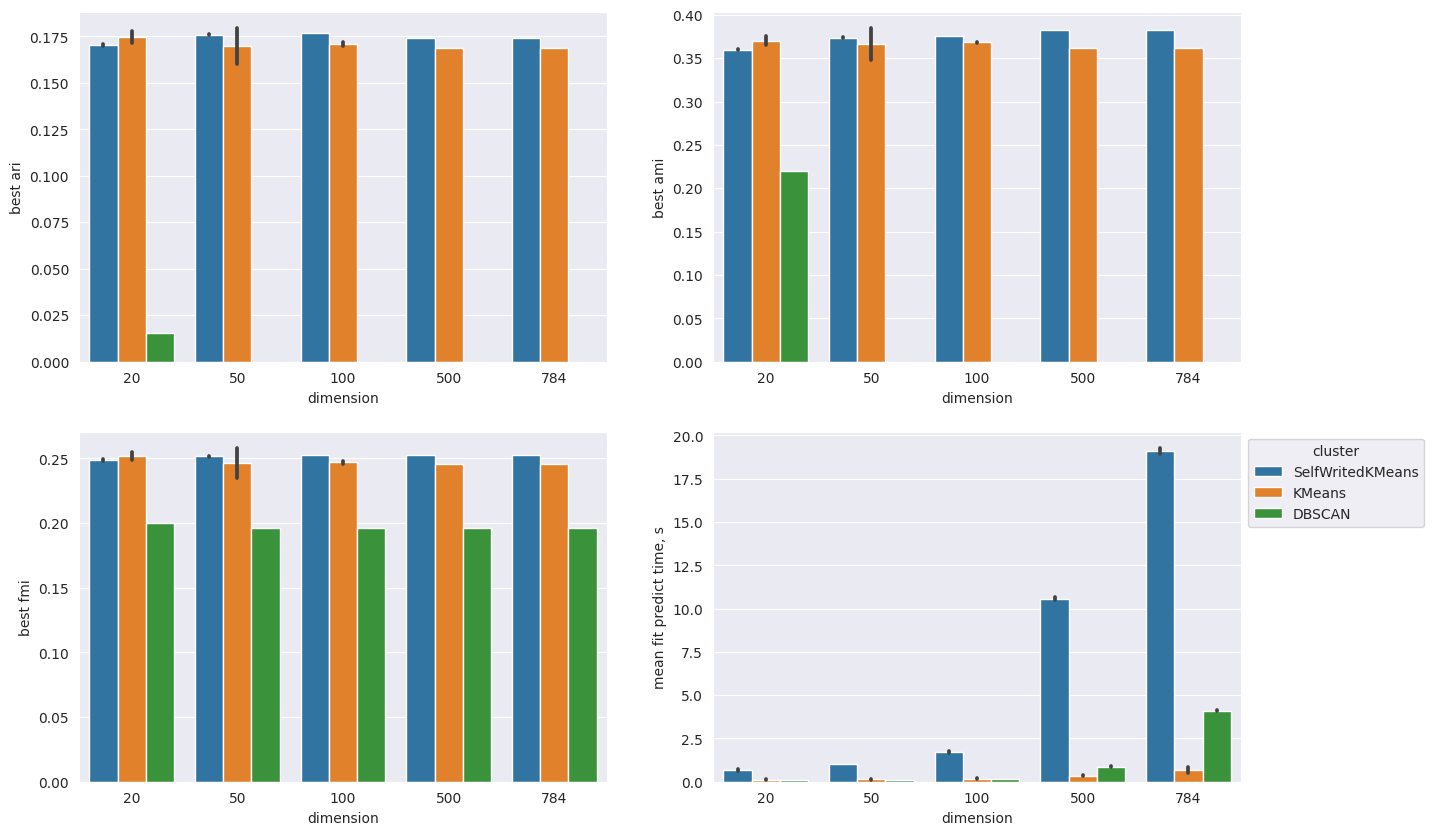

In [65]:
results = pd.read_csv(pathlib.Path("train_res.csv"))
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

for y, ax in zip(
    ["best ari", "best ami", "best fmi", "mean fit predict time, s"], axs.flatten()
):
    sns.barplot(results, x="dimension", y=y, hue="cluster", ax=ax)
    if y == "mean fit predict time, s":
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()


# Итоги

По скорости самописный KMean проигрывает конкурентам, так как в нём нет параллельной работы. Качеством же он почти не уступает библиотечной. DBSCAN проигрывает обоим в качестве.